##Kütüphanelerin yüklenmesi.

In [1]:
import numpy as np
import pandas as pd
import math
import shutil
import matplotlib.pyplot as plt
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
import xml.etree.ElementTree as ET


##Eğitilecek Klasörün İndirilmesi

thyroid.zip dosyasının dropbox üzerinden çekilmesi.


In [ ]:
!wget https://www.dropbox.com/s/jbwikf3mm2fzue9/thyroid.zip?dl=0
!unzip /content/thyroid.zip?dl=0

##Klasör içerisindeki Dosyaların Eğitim için Sınıflandırılması

Tirads özelliği ile kaç farklı değer olduğunun bulunması.

In [3]:
list = []
for i in range(1,400):
    if os.path.exists('thyroid/'+str(i)+'.xml') == True:
        tree = ET.parse('thyroid/'+str(i)+'.xml')
        root = tree.getroot()
        list.append(root[7].text)
        #print(i,': ',root[7].text)
list_uni = pd.Series(list).unique()
list_uni

#Not: Kod satırı çalıştığında  None, 2, 4a, 5, 4b, 4c, 3 olarak yedi farklı tirads değerinin olduğu görülebilir.

array([None, '2', '4a', '5', '4b', '4c', '3'], dtype=object)

Benign, Malign ve herhangi bir sınıfı temsil etmeyen None değerli görüntü sayısının belirlenmesi.

Not: 2, 3 benign yani iyi huylu. 4a, 4b, 4c ve 5 malign yani kötü huylu anlamına gelmektedir.

In [4]:
benigns_counter= 0
maligns_counter= 0
None_counter= 0
less= 0

for i in range(1,401):
    for j in range(1,3):
        if os.path.exists('thyroid/'+str(i)+'_'+str(j)+'.jpg') == True:
            tree = ET.parse('thyroid/'+str(i)+'.xml')
            root = tree.getroot()
            classes = root[7].text
            
            if classes== '2' or classes== '3':
                benigns_counter=benigns_counter +1
            elif classes== '4a' or classes== '4b' or classes== '4c' or classes == '5':
                maligns_counter= maligns_counter +1
            else:
                 None_counter= None_counter+ 1

print("benigns_counter: ",benigns_counter,"\n" 
      "maligns_counter:",maligns_counter,"\n"
      "None_counter:",None_counter)


if benigns_counter < maligns_counter:
    less= benigns_counter
else:
    less= maligns_counter

print("less:",less)

#Sonuçlara bakıldığında malign sayısının benign sayısından neredeyse 5 katı fazla olduğu görülebilir.

benigns_counter:  60 
maligns_counter: 283 
None_counter: 119
less: 60


Tirads skoru 2 ve 3 olanların benigns(yani iyi huylular) ve tirads skoru 4a, 4b, 4c, ve 5 olanların malign(yani kötü huylular) klasörlerine kopyalanması. 

Not: Bu iki klasör split klasörünün altındadır.

In [23]:
#benign/malign için klasor oluşturuluyor
os.mkdir('split')
os.mkdir('split/benigns')
os.mkdir('split/maligns')

#Not: Her bir klasördeki elemanın less değeri kadar eleman alması için sayaç görevi görecek değişkenlerin belirlenmesi.
be_holder= 0
ma_holder= 0


for i in range(1,401):
    for j in range(1,3):
        if os.path.exists('thyroid/'+str(i)+'_'+str(j)+'.jpg') == True:
            tree = ET.parse('thyroid/'+str(i)+'.xml')
            root = tree.getroot()
            classes = root[7].text
            
            if classes == '2' or classes == '3':
                if be_holder <= less: # Eleman sayısının less sayısı kadar olması sağlanıyor
                    shutil.copy('thyroid/'+str(i)+'_'+str(j)+'.jpg', 'split/benigns')
                    be_holder= be_holder + 1
            elif classes == '4a' or classes == '4b' or classes == '4c' or classes == '5':
                if ma_holder <= less: # Eleman sayısının less sayısı kadar olması sağlanıyor
                    shutil.copy('thyroid/'+str(i)+'_'+str(j)+'.jpg', 'split/maligns')
                    ma_holder= ma_holder + 1
#Not: kopyalamada benign ve malign klasörlerinin altındaki eleman sayılarının eşit olacak şekilde kopyalandı.

Yeni oluşturulacak compile klasörü altında split klasörünün içinde bulunan bütün verinin train, test ve val olarak üçe ayrılması

In [24]:
#görüntüler split klasörünün altındaki benigns ve maligns klasörünün altına kopyalandıktan sonra her klasörde 
#ne kadar sayıda görüntü olduğunu kontrol ediyoruz.  
ROOT_DIR = "split"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

number_of_images.items()

dict_items([('maligns', 61), ('benigns', 60)])

In [8]:
#datasetinin train, test, val olarak üçe ayıran fonksiyon
def dataFolder(p,split):
    if not os.path.exists ("./"+p):
        os.mkdir("./"+p)

        for dir in os.listdir(ROOT_DIR):
            os.makedirs("./"+p+"/"+dir)

            for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)) , 
                                size = (math.floor(split*number_of_images[dir]) -5), 
                                replace= False):
                O = os.path.join(ROOT_DIR,dir,img)
                D = os.path.join("./"+p,dir)
                shutil.copy(O,D)
                os.remove(O)
    else:
        print(f"{p} folder exist")

In [9]:
#compile isminde yeni bir klasör oluşturup datasetinin train, test, val olarak üçe ayrıldığı yer
os.mkdir('compile')
dataFolder("compile/train",0.7)
dataFolder("compile/test",0.25)
dataFolder("compile/val",0.25)

In [10]:
na_benigns = os.listdir('split/benigns') #split/benigns dizininin altında kalan dosya sayısı
na_maligns = os.listdir('split/maligns') #split/maligns dizininin altında kalan dosya sayısı

#kalan dosyaların compile/train klasörünün altına taşınması
for i in na_benigns:
    shutil.move('split/benigns/'+i, 'compile/train/benigns') 
for i in na_maligns:
    shutil.move('split/maligns/'+i, 'compile/train/maligns') 

## Model-1 (Bu CNN modeli sigmoid aktivasyon fonksiyonu ile binary sınıflandırma yapmaktadır)

###Verinin hazırlanması

image_count = number of epochs * batch size * steps_per_epoch

Not: Yukarıdaki formül uygun parametre değerleri için kullanılmıştır

In [ ]:
#Eğitime girecek görüntülerin ön işlemden geçtiği metotlar
def preprocessigImages1(path):
    image_data = ImageDataGenerator(zoom_range= 0.2, shear_range = 0.2, rescale= 1/225, horizontal_flip= True)
    image = image_data.flow_from_directory(directory = path, target_size = (224,224),batch_size = 6, class_mode = 'binary')
    return image

def preprocessigImages2(path):
    image_data = ImageDataGenerator(rescale= 1/225)
    image = image_data.flow_from_directory(directory = path, target_size = (224,224),batch_size = 6, class_mode = 'binary')
    return image

In [ ]:
#Verilerin eğitime hazır hale geldiği bilgisayarın görüntüleri anlayabileceği şekle gelmesi için ön işlem metotlarına gönderildiği kod bloğu
path = "compile/train"
train_data = preprocessigImages1(path)

path = "compile/val"
val_data = preprocessigImages2(path)

path = "compile/test"
test_data = preprocessigImages2(path)

Found 76 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [ ]:
# Sınıf bilgileri
train_data.class_indices

{'benigns': 0, 'maligns': 1}

###Modelin oluşturulması

In [ ]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), activation="relu", input_shape = (224, 224, 3) ))
model.add(MaxPool2D(pool_size=(2,2) ))

model.add(Conv2D(filters=36, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2) ))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2) ))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2) ))

model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=64, activation= 'relu'))
model.add(Dropout(rate = 0.25))
model.add(Dense(units=1, activation= 'sigmoid'))

model.summary()

In [ ]:
model.compile(optimizer='adam', loss = keras.losses.binary_crossentropy, metrics=['accuracy'])

In [84]:
# Modelin her eğitim içerisinde en iyi val_accuracy değerine sahip olan ağırlık değerlerine kaydetmesi
from keras.callbacks import ModelCheckpoint, EarlyStopping

# erken durdurma modelin en iyi duruma geldiği için eğitime devam etmemesi
es = EarlyStopping(monitor="val_accuracy", min_delta = 0.01, patience= 5, verbose=1, mode='auto')

# En iyi durumlarun kaydedilmesi 
mc = ModelCheckpoint(monitor='val_accuracy', filepath="./bestmodel1.h5", verbose=1, save_best= True, mode='auto')

cd = [es, mc]

In [ ]:
#Modelin eğitildiği kısım
hs = model.fit_generator(generator=train_data, 
                         steps_per_epoch=train_data.samples/train_data.batch_size,
                         validation_steps=val_data.samples/val_data.batch_size, 
                         epochs=30, 
                         verbose= 1, 
                         validation_data= val_data, 
                         callbacks= cd)

Grafik üzerinde değerlendirme.

In [ ]:
h = hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

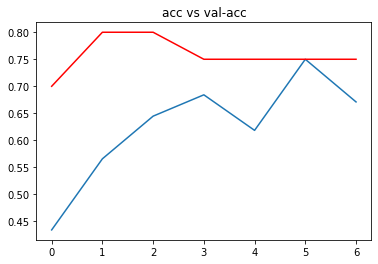

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c='red')

plt.title('acc vs val-acc')
plt.show()

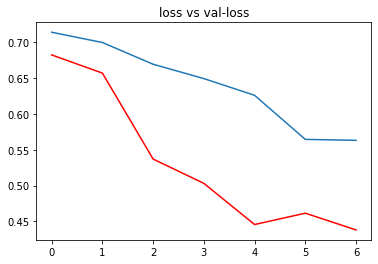

In [ ]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c='red')

plt.title('loss vs val-loss')
plt.show()

In [ ]:
# Eğitim içerisinde en iyi val_accuracy değere sahip olan kısımın test için yüklenmesi
from keras.models import load_model

model = load_model("bestmodel1.h5")

In [ ]:
#Test verileri ile model sınandığında %75 gibi bir değer karşımıza çıkıyor
#Bu değer ortalamanın üstü olsada yeterli değil
#Daha iyi sonuç alamamızın asıl sebebi elimizde az verinin olması

acc = model.evaluate(test_data)[1]

print(f"the accuracy of our model is {acc*100} %")

4/4 [==============================] - 1s 86ms/step - loss: 0.4597 - accuracy: 0.7500
the accuracy of our model is 75.0 %


Model doğruluk oranına bakıldığında %90 gibi bir doğruluk oranı yakalandığı görülebilir.

Tahmin

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


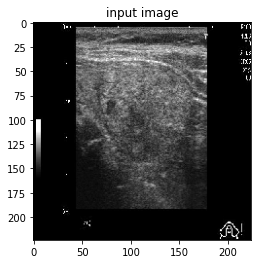

(224, 224, 3)
1 

Maligin


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
#Tahmin edilecek görüntünün çağırılması
path = "/content/compile/test/maligns/21_1.jpg"
img = load_img(path, target_size= (224, 224))
input_arr = img_to_array(img)/225

#tahmin edilecek görüntünün ekrana basılması
plt.imshow(input_arr)
plt.title("input image")
plt.show()

#görüntünün tahmine hazır hale getirilmesi
#print(input_arr.shape)
input_arr = np.expand_dims(input_arr, axis=0)

#tahmin işlemenin yapılması
pred = model.predict_classes(input_arr)[0][0]
#print(pred.shape)
print(pred,"\n") 

#tahmin işleminin cevabının ekrana basılması
if pred == 0:
    print("Benign")
else:
    print("Maligin")


Not1: Eğer eğitim için aynı sayıda benign ve malgin görüntüleri seçilirse accuracy oranı %75 bir seviyede oluyor. Test için ayrılan malign değerlerinin hepsini doğru tahmin ederken benign değerlerin yarısından biraz daha fazlasını tahmin edebiliyor.

Not2: Eğer eğitim için bütün değerler kullanılırsa yani malign değeri benign değerinin 5 katı kadar fazla görüntü olmuş oluyor. O zaman %90 bir accuracy oranı almasına rağmen hiçbir benin değerini doğru tahmin edemiyor. Yanı her iki sınıftanda aynı sayıda görüntü olması daha isabetli tahminler yapılmasını sağlar.

## Model- 2 (CNN VGG16)

Standart bir CNN modeli olan VGG16 softmax aktivasyon fonksiyonu ile regresyona dayalı bir tahmin yapılmaktadır

In [71]:
#Eğitime girecek görüntülerin ön işlemden geçdiği kod bloğu
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="compile6/train", batch_size = 10, target_size=(224,224))


tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="compile6/test", batch_size = 10, target_size=(224,224))

vldata = ImageDataGenerator()
valdata = vldata.flow_from_directory(directory="compile6/val", batch_size = 10, target_size=(224,224))

Found 76 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=2, activation="softmax"))

model.summary()

In [73]:
from keras.optimizer_v1 import Adam
from tensorflow import keras
opt = keras.optimizers.Adam(learning_rate=0.001)

In [76]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

In [82]:
# Modelin her eğitim içerisinde en iyi val_accuracy değerine sahip olan ağırlık değerlerine kaydetmesi
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("./vgg16_2.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto')

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')


In [ ]:
hist = model.fit_generator(steps_per_epoch=traindata.samples/traindata.batch_size,
                           validation_steps=valdata.samples/valdata.batch_size,
                           generator=traindata, 
                           validation_data= valdata, 
                           epochs=15,
                           verbose= 1,
                           callbacks=[early,checkpoint])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
7/7 [==============================] - 161s 21s/step - loss: 0.6905 - accuracy: 0.4737 - val_loss: 0.6790 - val_accuracy: 0.6500

Epoch 00001: saving model to ./bestmodel1.h5


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f8ac0bec680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 2/15
1/7 [==>...........................] - ETA: 2:09 - loss: 0.6827 - accuracy: 0.7000

Grafik üzerinde değerlendirme.


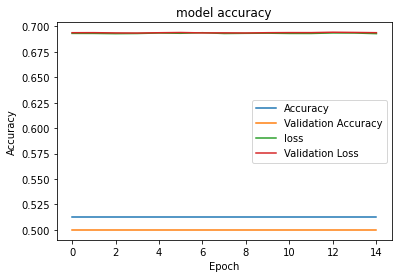

In [66]:
h = hist.history
h.keys()

plt.plot(h["accuracy"])
plt.plot(h['val_accuracy'])
plt.plot(h['loss'])
plt.plot(h['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [68]:
# Eğitim içerisinde en iyi val_accuracy değere sahip olan kısımın test için yüklenmesi
from keras.models import load_model
saved_model = load_model("vgg16_1.h5")

[[0.48289376 0.51710624]]
dog


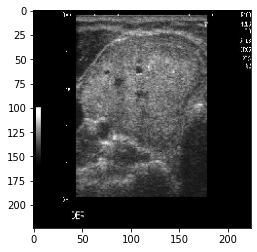

In [70]:
from keras.preprocessing import image

#Tahmin edilecek görüntünün çağırılması
img = image.load_img("/content/compile6/test/benigns/130_1.jpg",target_size=(224,224))
img = np.asarray(img)

#tahmin edilecek görüntünün ekrana basılması
plt.imshow(img)

#görüntünün tahmine hazır hale getirilmesi
img = np.expand_dims(img, axis=0)
output = saved_model.predict(img)
#output = model.predict(img)
print(output)

#tahmin işleminin cevabının ekrana basılması
if output[0][0] > output[0][1]:
    print("cat")
else:
    print('dog')

In [ ]:
#acc = saved_model.evaluate_generator(testdata)[1]
acc = saved_model.evaluate(testdata)[1]

print(f"the accuracy of our model is {acc*100} %")

2/2 [==============================] - 0s 111ms/step - loss: 0.6932 - accuracy: 0.5000
the accuracy of our model is 50.0 %


##Model 3 (Support Vector Machine)

In [11]:
from skimage.transform import resize
from skimage.io import imread

In [25]:
Categories=['benigns','maligns'] #etiketlerin oluşturulması
flat_data_arr=[]                 #eğitilecek veri
target_arr=[]                    #etiketler

datadir='/content/split'  #verilerin yüklenmesi

In [26]:
#eğitilecek görüntüleri bir array dizisi haline getirildiği yer
for i in Categories:
    
    print(f'kategori yükleniyor : {i}')
    path=os.path.join(datadir,i)
    for img in os.listdir(path):
        img_array=imread(os.path.join(path,img))
        img_resized=resize(img_array,(150,150,3))
        flat_data_arr.append(img_resized.flatten())
        target_arr.append(Categories.index(i))
    print(f'kategori yüklendi:{i} başarılı')

flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data) #dataframe
df['Target']=target
x=df.iloc[:,:-1] #input data 
y=df.iloc[:,-1] #output data

kategori yükleniyor : benigns
kategori yüklendi:benigns başarılı
kategori yükleniyor : maligns
kategori yüklendi:maligns başarılı


In [28]:
#Support Vector Machine modelinin oluşturulması
from sklearn import svm
from sklearn.model_selection import GridSearchCV
param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
svc=svm.SVC(probability=True)
model=GridSearchCV(svc,param_grid)

In [29]:
#Verinin Train Test olarak ikiye ayrılması
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=77,stratify=y)
print('Veriler başarılı bir şekilde ayrıldı.')

Veriler başarılı bir şekilde ayrıldı.


In [30]:
 #Eğitimin yapılması
model.fit(x_train,y_train)
print('Eğitim sona erdi.')
# model.best_params_ contains the best parameters obtained from GridSearchCV

Eğitim sona erdi.


In [31]:
#Tahmin
from sklearn.metrics import accuracy_score
y_pred=model.predict(x_test)
print("The predicted Data is :")
print(y_pred)
print("The actual data is:")
print(np.array(y_test))
print(f"The model is {accuracy_score(y_pred,y_test)*100}% accurate")

The predicted Data is :
[0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 1 1 0 1 1 0 1 1 1 0]
The actual data is:
[0 0 0 1 1 1 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 0 1 0 1]
The model is 72.0% accurate


##Model 4 (Random Forest)

In [32]:
#Random Forest modelinin oluşturulması ve eğitim

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
clf = GridSearchCV(rf, param_grid={'n_estimators':[100,200],'min_samples_leaf':[2,3]})
model = clf.fit(x_train,y_train)


In [33]:
#Tahmin
import sklearn

y_pred_test = model.predict(x_test)
print(f"The model is {accuracy_score(y_pred_test,y_test)*100}% accurate")

print("Test data metrics:")
print(sklearn.metrics.classification_report(y_true= y_test, y_pred= y_pred_test))

The model is 72.0% accurate
Test data metrics:
              precision    recall  f1-score   support

           0       0.78      0.58      0.67        12
           1       0.69      0.85      0.76        13

    accuracy                           0.72        25
   macro avg       0.73      0.71      0.71        25
weighted avg       0.73      0.72      0.71        25

